In [1]:
# Import necessary libraries for the project

# pandas: A powerful library for data manipulation and analysis, especially for working with DataFrame
import pandas as pd  

# numpy: A fundamental library for numerical operations and handling arrays
import numpy as np  

# xgboost: Efficient gradient boosting for classification and regression tasks
import xgboost as xgb  

# hyperopt: Library for hyperparameter optimization with functions like fmin, tpe, hp, and Trials for result tracking
from hyperopt import fmin, tpe, hp, Trials  

# mean_squared_error: Function from scikit-learn for calculating Mean Squared Error, useful for regression performance evaluation
from sklearn.metrics import mean_squared_error  

# matplotlib.pyplot: For plotting and graphing visualizations
import matplotlib.pyplot as plt  

# shap: Library for SHapley Additive exPlanations, used for model interpretability and feature importance
import shap


C:\Users\HP\anaconda3\envs\experimentation\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install shap

### Parameters

In [3]:
# Define the product key and the target variable for analysis
product_key = "PQ001"  # Product identifier

# Define the target variable to analyze (e.g., the variable to predict or examine)
y_variable = "units_sold"  # The variable representing units sold

# Set the correlation threshold for filtering features
correlation_threshold = 0.85  # Features with a correlation greater than this will be considered highly correlated
folder=r"C:\Users\HP\Desktop\financce_time_series_project"


In [4]:
# Load the datasets from CSV files into pandas DataFrames

# Read the 6-month forecast data and store it in the 'features_6_months' DataFrame
# This dataset contains the forecasted values for the next 6 months
features_6_months = pd.read_csv(folder+r"\6_month_forecast.csv")

# Read the macroeconomic factors data and store it in the 'macro_factors' DataFrame
# This dataset contains various macroeconomic indicators that might impact sales
macro_factors = pd.read_csv(folder+r"\macro_economic_factors.csv")

# Read the product sales data and store it in the 'product_synthetic_data' DataFrame
# This dataset contains historical sales data for the products
product_synthetic_data = pd.read_csv(folder+ r"\product_sales.csv")


In [5]:
# Display the synthetic data (for visualization purposes)
# Uncomment the next line to display the synthetic data to the user in an interactive manner
# import ace_tools as tools  # Import the ace_tools library for data visualization
# tools.display_dataframe_to_user(name="Synthetic Product Data", dataframe=synthetic_data)

# Filter the synthetic product data for a specific product using the product_key
# This will return data only for the product specified by the product_key ("PQ001" in this case)
product = product_synthetic_data[product_synthetic_data["product_id"] == product_key]

# Optionally, you can select specific columns from the dataset
# Uncomment the next line to filter only the relevant columns for analysis
# product = product[["product_id", "date", "year", "month", "units_sold"]]  # Filter relevant columns

# Display the first few rows of the filtered product data for inspection
product.head()  # Show the first 5 rows of the filtered product data


,product_id,date,year,month,revenue,units_sold,price,volume
0,PQ001,2019-01-01,2019,1,4086.507644,185,22.089231,371.417242
1,PQ001,2019-02-01,2019,2,4341.631323,647,6.710404,900.994964
2,PQ001,2019-03-01,2019,3,4704.776274,354,13.290328,738.411865
3,PQ001,2019-04-01,2019,4,1888.303483,863,2.188069,815.293628
4,PQ001,2019-05-01,2019,5,3058.734468,702,4.357172,796.455992


In [6]:
# Rename the 'date' column to 'Date' for consistency or clarity in naming
# This ensures that the column name matches the desired format
product.rename(columns={"date": "Date"}, inplace=True)

# Drop the 'price' column as it is not required for further analysis
# The 'axis=1' argument specifies that we're dropping a column (not a row)
product.drop("price", axis=1, inplace=True)

# Display the first 2 rows of the updated product data
# This helps to quickly inspect the changes made to the DataFrame
product.head(2)


C:\Users\HP\AppData\Local\Temp\ipykernel_10252\3044120315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product.rename(columns={"date": "Date"}, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_10252\3044120315.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product.drop("price", axis=1, inplace=True)


,product_id,Date,year,month,revenue,units_sold,volume
0,PQ001,2019-01-01,2019,1,4086.507644,185,371.417242
1,PQ001,2019-02-01,2019,2,4341.631323,647,900.994964


In [7]:
# Convert the 'Date' column in the 'product' DataFrame to a datetime object
# This ensures that the 'Date' column is in the proper datetime format for time-based analysis
product["Date"] = pd.to_datetime(product["Date"])

# Convert the 'Date' column in the 'macro_factors' DataFrame to a datetime object
# Similar to the previous step, this ensures that the 'Date' column in macro_factors is in the proper datetime format
macro_factors["Date"] = pd.to_datetime(macro_factors["Date"])


C:\Users\HP\AppData\Local\Temp\ipykernel_10252\2564733466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product["Date"] = pd.to_datetime(product["Date"])


In [8]:
# Merge the 'macro_factors' and 'product' DataFrames on the 'Date' column
# The 'how="right"' argument performs a right join, which means all rows from the 'product' DataFrame
# will be retained, and only matching rows from the 'macro_factors' DataFrame will be included.
# This is useful when you want to keep all product data, even if there are no corresponding macroeconomic factors.

merged_df = pd.merge(macro_factors, product, on="Date", how="right")

# The above merge operation results in a DataFrame where the columns from both 'macro_factors' and 'product'
# are combined based on the common 'Date' column.


In [9]:
# Drop unnecessary columns from the merged DataFrame to focus on the relevant data
# The columns 'month', 'revenue', and 'volume' are dropped since they are not needed for further analysis
# 'axis=1' specifies that we're dropping columns (not rows), and 'inplace=True' modifies the DataFrame directly
merged_df.drop(['month', 'revenue', 'volume'], axis=1, inplace=True)


In [10]:
##columns_to_drop = ['month', 'volume'] + [col for col in merged_df.columns if col != y_variable and col not in ['month', 'volume']]
##merged_df.drop(columns_to_drop,axis=1,inplace=True)

### Train test validation split

In [11]:
# --- 🔵 Define the Date Range and Product Names ---
# Set the start and end dates for the analysis period
start_date = '2019-01-01'  # Start date for the date range
end_date = '2025-02-01'  # End date for the date range

# Create a range of dates with a monthly frequency (MS = Month Start)
# This will generate a list of the first day of each month from start_date to end_date
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

# --- 🔵 Splitting the Data into Train, Validation, and Test Sets ---
# Define specific dates to split the data into training, validation, and test sets
train_end_date = pd.to_datetime('2024-01-31')  # The last date for the training data (6 months before the end date)
validation_start_date = pd.to_datetime('2024-02-01')  # The start date for the validation period
test_start_date = pd.to_datetime('2024-09-01')  # The start date for the test period

# --- 🔵 Train, Validation, and Test Split ---
# Filter the merged data to create separate datasets for training, validation, and testing

# Training data: Contains all data before the 'train_end_date'
train_data = merged_df[merged_df['Date'] < train_end_date]

# Validation data: Contains data from the start of the validation period until just before the test period
validation_data = merged_df[(merged_df['Date'] >= validation_start_date) & (merged_df['Date'] < test_start_date)]

# Test data: Contains all data from the start of the test period onward
test_data = merged_df[merged_df['Date'] >= test_start_date]


In [12]:
# Drop the 'product_id' column from the merged DataFrame
# The 'axis=1' argument specifies that we are dropping a column (not a row)
# 'inplace=True' modifies the DataFrame directly without the need to assign the result to a new variable
merged_df.drop(["product_id"], axis=1, inplace=True)


### Correlation based feature selection

In [13]:
# --- 🔵 Import necessary libraries ---
import pandas as pd  # For data manipulation and analysis

# --- 🔵 Ensure the merged_df DataFrame is available and correctly formatted ---
# The merged_df DataFrame must contain the necessary columns and data to proceed with analysis.

# --- 🔵 Define Date Variables for Splitting Data ---
# Specify the end dates for training, validation, and test periods.
train_end_date = pd.to_datetime('2024-01-01')  # End of the training data
validation_start_date = pd.to_datetime('2024-02-01')  # Start of the validation data
test_start_date = pd.to_datetime('2024-08-01')  # Start of the test data

# --- 🔵 Data Splitting ---
# Split the merged_df DataFrame into train, validation, and test datasets based on the defined dates.
train_data = merged_df[merged_df['Date'] < train_end_date]
validation_data = merged_df[(merged_df['Date'] >= validation_start_date) & (merged_df['Date'] < test_start_date)]
test_data = merged_df[merged_df['Date'] >= test_start_date]

# --- 🔵 Check Data Sizes ---
# Print the sizes of the train, validation, and test datasets to ensure that the splits are non-empty.
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

# --- 🔵 Ensure Validation Data is Not Empty ---
# If the validation data is empty, raise an error indicating an issue with the date filtering.
if validation_data.empty:
    raise ValueError("Validation data is empty. Please check the date filtering conditions.")

# --- 🔵 Define Features (X) and Target (y) ---
# For each dataset (train, validation, test), drop the 'Date' and target variable columns to get the features (X),
# and store the target variable (y) in separate variables.

X_train = train_data.drop(columns=[y_variable, 'Date'])  # Features for training data
y_train = train_data[y_variable]  # Target for training data

X_validation = validation_data.drop(columns=[y_variable, 'Date'])  # Features for validation data
y_validation = validation_data[y_variable]  # Target for validation data

X_test = test_data.drop(columns=[y_variable, 'Date'])  # Features for test data
y_test = test_data[y_variable]  # Target for test data

# --- 🔵 Feature Selection via Correlation Matrix ---
# Calculate the correlation matrix to identify highly correlated features in the training data.
corr_matrix = X_train.corr()

# Create a set to store features that have high correlation (above the threshold)
high_corr_var = set()

# Loop through the upper triangle of the correlation matrix to find correlations above the defined threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:  # If the correlation is greater than the threshold
            colname = corr_matrix.columns[i]  # Get the column name of the highly correlated feature
            high_corr_var.add(colname)  # Add the column name to the set of high correlation features

# --- 🔵 Drop Highly Correlated Features ---
# Remove the highly correlated features from the training data
X_train_reduced = X_train.drop(columns=high_corr_var)

# Apply the same feature selection to the validation and test datasets
# The selected features from the training data are used to reduce the validation and test datasets
X_validation_reduced = X_validation[X_train_reduced.columns]  # Select the features that match the reduced train data
X_test_reduced = X_test[X_train_reduced.columns]  # Select the features that match the reduced train data

# --- 🔵 Display Feature Reduction Results ---
# Print the number of features before and after the reduction to see how much the feature space was reduced.
print(f"Original number of features in train data: {len(X_train.columns)}")
print(f"Reduced number of features in train data: {len(X_train_reduced.columns)}")

# Optionally, print the first few rows of the reduced datasets to inspect the changes
# print(X_train_reduced.head())
# print(X_validation_reduced.head())
# print(X_test_reduced.head())

# --- 🔵 Update the Feature Sets ---
# Replace the original feature sets with the reduced feature sets for further modeling
X_train = X_train_reduced
X_validation = X_validation_reduced
X_test = X_test_reduced


Train data size: 60
Validation data size: 6
Test data size: 7
Original number of features in train data: 30
Reduced number of features in train data: 28


### Xgboost model building

In [14]:
# --- 🔵 Import necessary libraries ---
import xgboost as xgb  # For the XGBoost model, an efficient gradient boosting algorithm
import numpy as np  # For numerical operations, especially working with arrays
from hyperopt import hp, fmin, tpe, Trials  # For hyperparameter optimization using Hyperopt
from sklearn.metrics import mean_squared_error  # For evaluating model performance using RMSE (Root Mean Squared Error)
import pickle

# --- 🔵 Define Hyperparameter Search Space ---
# The 'space' variable defines the search space for hyperparameter optimization.
# Hyperopt's 'hp' module is used to specify the ranges and choices for different hyperparameters.
space = {
    'max_depth': hp.choice('max_depth', range(3, 15)),  # Maximum depth of the tree (choice between 3 and 15)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),  # Learning rate (uniform distribution between 0.01 and 0.1)
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),  # Number of trees (100 to 500)
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Subsample ratio (between 0.5 and 1.0)
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Column sample ratio (between 0.5 and 1.0)
    'gamma': hp.uniform('gamma', 0, 5),  # Minimum loss reduction required to make a further partition (between 0 and 5)
    'min_child_weight': hp.choice('min_child_weight', [1, 3, 5, 7])  # Minimum sum of instance weight (1, 3, 5, or 7)
}

# --- 🔵 Define Objective Function for Hyperopt ---
# The 'objective' function defines how Hyperopt evaluates each set of hyperparameters.
# The function trains a model, makes predictions, and returns the RMSE for validation data to be minimized.

def objective(params):
    # Initialize XGBoost Regressor model with the given hyperparameters
    model = xgb.XGBRegressor(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        objective='reg:squarederror',  # Objective function for regression
        eval_metric='rmse'  # Evaluation metric: Root Mean Squared Error (RMSE)
    )
    
    # Train the model on the training data and validate on the validation set
    model.fit(
        X_train, y_train,  # Training data
        eval_set=[(X_validation, y_validation)],  # Validation data for evaluation
        verbose=False  # Turn off verbose output during training
    )
    
    # Make predictions on the validation set
    y_pred = model.predict(X_validation)
    
    # Calculate RMSE (Root Mean Squared Error) on the validation set
    rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
    
    return rmse  # Return RMSE to Hyperopt for optimization

# --- 🔵 Hyperparameter Optimization using Hyperopt ---
# Initialize Trials object to track the progress of optimization
trials = Trials()

# Perform the optimization process to find the best hyperparameters
best = fmin(fn=objective,  # The objective function to minimize (RMSE)
            space=space,  # The hyperparameter search space
            algo=tpe.suggest,  # Tree of Parzen Estimators (TPE) for optimization
            max_evals=50,  # Number of iterations to run Hyperopt
            trials=trials)  # Store the trial results

# Print the best hyperparameters found by Hyperopt
print(f"Best hyperparameters: {best}")

# --- 🔵 Train the Final Model using the Best Hyperparameters ---
# Initialize the final XGBoost model with the best hyperparameters
best_model = xgb.XGBRegressor(
    max_depth=best['max_depth'],
    learning_rate=best['learning_rate'],
    n_estimators=best['n_estimators'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    min_child_weight=best['min_child_weight'],
    objective='reg:squarederror',
    eval_metric='rmse'
)

# Train the model on the full training data (X_train and y_train)
best_model.fit(X_train, y_train, eval_set=[(X_validation, y_validation)], verbose=False)

with open(folder+r"\best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# --- 🔵 Model Evaluation on Test Data ---
# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate model performance on the test data using RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print the RMSE on the test data
print(f"Test RMSE: {test_rmse}")


100%|█████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86trial/s, best loss: 270.1580555896862]
Best hyperparameters: {'colsample_bytree': 0.9661307285042285, 'gamma': 0.0053153866728476995, 'learning_rate': 0.04475658123574568, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 3, 'subsample': 0.5515596095137206}
Test RMSE: 235.5216533967737


In [15]:
y_test_pred

array([554.9458 , 540.18494, 546.8369 , 555.4458 , 555.0574 , 531.8161 ,
       533.6971 ], dtype=float32)

## Feature importance

In [16]:
X_train.head(2)

,GDP Growth Rate (%),"Inflation Rate (CPI, %)",Federal Reserve Interest Rate (%),Unemployment Rate (%),Consumer Confidence Index,Government Debt (% of GDP),Trade Balance (Billion $),"Oil Price (WTI, $/barrel)",Stock Market Index (S&P 500),Housing Market Index,...,Defense Spending (Billion $),Fintech Transactions (Trillion $),E-commerce Share of Retail (%),Agricultural Output Index,Freight Index,Industrial Production Index,Media Ad Revenue (Billion $),Tourism Revenue (Billion $),Telecom Broadband Subscriptions (Million),Mining Output Index
0,34.753277,24.009746,61.754300,94.648475,75.362086,36.037099,57.020143,71.309268,41.191629,70.524201,...,95.045574,113.108919,69.053397,51.202834,85.677744,76.385747,46.099187,78.465320,93.431948,36.166453
1,40.183345,25.273854,61.291933,104.094969,79.486368,32.773947,66.597316,65.729844,40.960473,72.433344,...,93.879989,94.864156,67.305381,49.334703,86.801420,76.768450,53.521819,83.285729,88.106828,35.370784


In [17]:
print(X_train.columns)

Index(['GDP Growth Rate (%)', 'Inflation Rate (CPI, %)',
       'Federal Reserve Interest Rate (%)', 'Unemployment Rate (%)',
       'Consumer Confidence Index', 'Government Debt (% of GDP)',
       'Trade Balance (Billion $)', 'Oil Price (WTI, $/barrel)',
       'Stock Market Index (S&P 500)', 'Housing Market Index',
       'Business Investment Growth (%)', 'Manufacturing PMI',
       'Supply Chain Index', 'Labor Productivity Growth (%)',
       'Renewable Energy Share (%)', 'Healthcare Expenditure (% of GDP)',
       'Real Estate Price Index', 'Automotive Sales (Million Units)',
       'Defense Spending (Billion $)', 'Fintech Transactions (Trillion $)',
       'E-commerce Share of Retail (%)', 'Agricultural Output Index',
       'Freight Index', 'Industrial Production Index',
       'Media Ad Revenue (Billion $)', 'Tourism Revenue (Billion $)',
       'Telecom Broadband Subscriptions (Million)', 'Mining Output Index'],
      dtype='object')


Feature Importance: {'GDP Growth Rate (%)': 2.0, 'Inflation Rate (CPI, %)': 1.0, 'Federal Reserve Interest Rate (%)': 1.0, 'Unemployment Rate (%)': 1.0, 'Government Debt (% of GDP)': 1.0, 'Oil Price (WTI, $/barrel)': 1.0, 'Housing Market Index': 1.0, 'Business Investment Growth (%)': 1.0, 'Supply Chain Index': 3.0, 'Labor Productivity Growth (%)': 3.0, 'Automotive Sales (Million Units)': 1.0, 'Industrial Production Index': 1.0, 'Media Ad Revenue (Billion $)': 1.0, 'Tourism Revenue (Billion $)': 2.0}


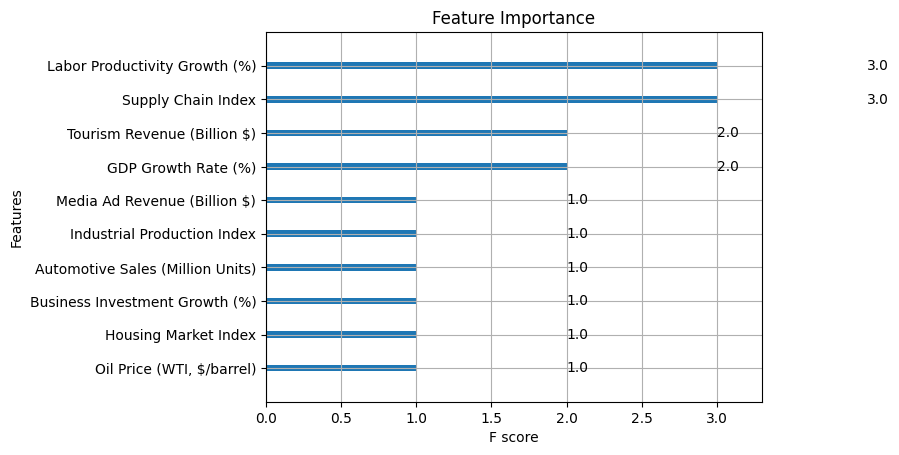

In [18]:
# --- 🔵 Get Feature Importance ---
# Extract feature importance from the trained XGBoost model.
# The 'get_score' method returns the importance of features based on the specified importance type.
# 'weight' represents the number of times a feature is used in a split, but other options include 'gain' (contribution to model improvement) or 'cover' (coverage of the feature).
importance = best_model.get_booster().get_score(importance_type='weight')  # Other options: 'gain', 'cover'
print(f"Feature Importance: {importance}")

# --- 🔵 Plot Feature Importance ---
# Plot the feature importance to visually assess which features are most important in the model.
# The plot displays the top features based on their importance, helping us understand which features drive predictions.

#plt.figure(figsize=(10, 6))  # Set the figure size for the plot
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)  # Plot top 10 features (adjust as needed)
plt.title('Feature Importance')  # Title of the plot
plt.show()  # Display the plot

# --- 🔵 SHAP Explainability ---
# SHAP (SHapley Additive exPlanations) helps in explaining the model's predictions by calculating the contribution of each feature.
# This makes the model more interpretable and provides insights into how each feature influences the predictions.

# Create a SHAP explainer object to compute SHAP values for the model
explainer = shap.Explainer(best_model, X_train)

# Get SHAP values for the test data to interpret the model's predictions on unseen data


In [19]:
#shap_values = explainer(X_test)

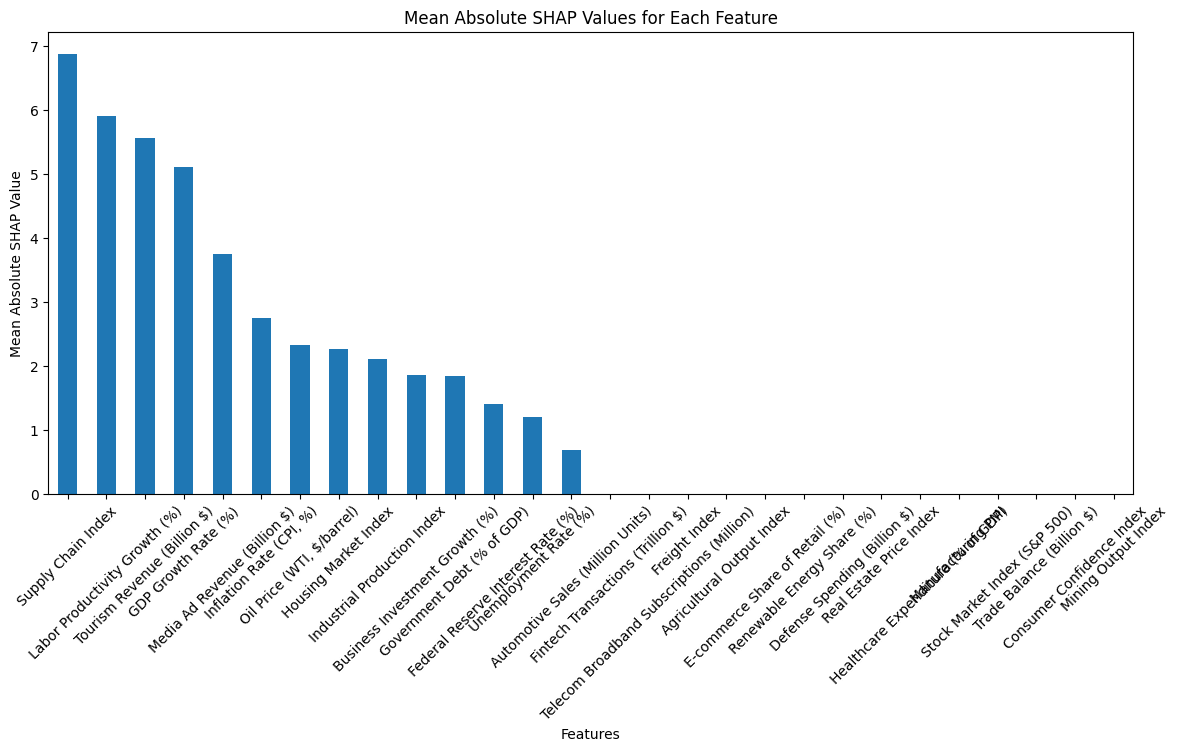

In [20]:
# --- 🔵 SHAP Feature Importance ---
# Use the SHAP explainer to calculate the SHAP values for the training data (X_train).
# SHAP values indicate the contribution of each feature to the model's predictions.
shap_feature_importance = explainer(X_train)

# --- 🔵 Convert SHAP Values to DataFrame ---
# Convert the SHAP values into a pandas DataFrame for easy manipulation and analysis.
# Each column corresponds to a feature, and each row corresponds to a data point.
shap_df_train = pd.DataFrame(shap_feature_importance.values, columns=X_train.columns)

# --- 🔵 Calculate Mean Absolute SHAP Values ---
# Calculate the mean absolute SHAP values for each feature across all data points in the training data.
# This helps in understanding the average impact of each feature on the model’s predictions.
mean_shap_values_train = shap_df_train.abs().mean()

# --- 🔵 Sort SHAP Values ---
# Sort the features by their mean absolute SHAP values in descending order.
# This allows us to identify which features have the largest average impact on predictions.
mean_shap_values_train = mean_shap_values_train.sort_values(ascending=False)

# --- 🔵 Plot Feature Importance ---
# Create a bar plot to visualize the mean absolute SHAP values for each feature.
# This plot will show which features, on average, contribute the most to the model's predictions.
plt.figure(figsize=(14, 6))  # Set the figure size for better readability
mean_shap_values_train.plot(kind='bar')  # Create the bar plot
plt.title('Mean Absolute SHAP Values for Each Feature')  # Title of the plot
plt.xlabel('Features')  # X-axis label
plt.ylabel('Mean Absolute SHAP Value')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the feature names for better visibility
plt.show()  # Display the plot


In [21]:
#print(X_train.columns)

## SHAP explanations for predictions on field data

In [22]:
features_6_months.to_csv(folder+r"\6_month_forecast.csv",index=False)

In [23]:
# --- 🔵 Align Features for Prediction ---
# Select the same features from the 'features_6_months' DataFrame as in the training set.
# The 'list(X_train.columns)' ensures that we are selecting the columns that match the features used during training.
X_field = features_6_months[list(X_train.columns)]

# --- 🔵 Make Predictions on Test Data ---
# Use the trained model ('best_model') to predict the target variable on the test set (X_test).
# The 'predict' method generates predictions based on the features in X_test.
y_field_pred = best_model.predict(X_field)


In [24]:
pd.DataFrame(y_field_pred).rename(columns={0:"sales_predictions"}).to_csv(folder+r"\predictions.csv",index=False)

In [25]:
features_6_months

,GDP Growth Rate (%),"Inflation Rate (CPI, %)",Federal Reserve Interest Rate (%),Unemployment Rate (%),Consumer Confidence Index,Retail Sales Growth (%),Government Debt (% of GDP),Trade Balance (Billion $),"Oil Price (WTI, $/barrel)",Stock Market Index (S&P 500),...,Defense Spending (Billion $),Fintech Transactions (Trillion $),E-commerce Share of Retail (%),Agricultural Output Index,Freight Index,Industrial Production Index,Media Ad Revenue (Billion $),Tourism Revenue (Billion $),Telecom Broadband Subscriptions (Million),Mining Output Index
0,0.343186,-0.016676,-0.022439,0.033476,0.026517,0.265522,0.066256,0.333334,0.009190,-0.022128,...,0.294150,0.289718,0.024314,0.371115,0.338357,0.007697,0.016591,0.216670,0.021087,-0.003649
1,0.333532,-0.014437,-0.015449,0.029009,0.024110,0.258911,0.059035,0.322547,0.008354,-0.019786,...,0.292176,0.278334,0.022466,0.359150,0.326666,0.015102,0.015579,0.215482,0.018775,-0.003159
2,0.321936,-0.011844,-0.006946,0.023930,0.020954,0.251318,0.050492,0.309806,0.007272,-0.016947,...,0.289990,0.264984,0.019998,0.344971,0.312806,0.023843,0.014002,0.214236,0.016013,-0.002708
3,0.309070,-0.009330,0.003054,0.018935,0.016779,0.243316,0.040609,0.295687,0.005881,-0.013391,...,0.287731,0.249804,0.016266,0.328782,0.297401,0.033921,0.011561,0.213401,0.012734,-0.002130
4,0.298363,-0.007187,0.011317,0.014745,0.013360,0.236682,0.032452,0.283954,0.004668,-0.010520,...,0.285882,0.237326,0.013324,0.315434,0.284675,0.042175,0.009554,0.212739,0.010027,-0.001676
5,0.287862,-0.004959,0.019550,0.010566,0.009412,0.230357,0.024813,0.272514,0.003384,-0.007630,...,0.284477,0.225720,0.010192,0.302967,0.272141,0.049936,0.007283,0.212119,0.007344,-0.001605


In [26]:
# --- 🔵 Import Necessary Libraries ---
import shap  # Import SHAP for model explainability and feature contribution analysis
import pandas as pd  # Import pandas for data manipulation and creating DataFrames

# --- 🔵 Calculate SHAP Values for Test Data ---
# Assuming 'explainer' is your SHAP explainer object (previously created) and 'X_field' is the input data for predictions.
# The 'explainer' calculates SHAP values, which represent the contribution of each feature to the model's predictions.
shap_values = explainer(X_field)

# --- 🔵 Convert SHAP Values to DataFrame ---
# Convert the SHAP values to a pandas DataFrame for easier manipulation and analysis.
# Each column corresponds to a feature from 'X_field', and each row represents the SHAP value for a given data point.
shap_df = pd.DataFrame(shap_values.values, columns=X_field.columns)

# Display the SHAP DataFrame to examine the feature contributions
shap_df  # This will display the DataFrame with SHAP values for each feature in the test data


,GDP Growth Rate (%),"Inflation Rate (CPI, %)",Federal Reserve Interest Rate (%),Unemployment Rate (%),Consumer Confidence Index,Government Debt (% of GDP),Trade Balance (Billion $),"Oil Price (WTI, $/barrel)",Stock Market Index (S&P 500),Housing Market Index,...,Defense Spending (Billion $),Fintech Transactions (Trillion $),E-commerce Share of Retail (%),Agricultural Output Index,Freight Index,Industrial Production Index,Media Ad Revenue (Billion $),Tourism Revenue (Billion $),Telecom Broadband Subscriptions (Million),Mining Output Index
0,-5.674301,1.537845,-0.337166,-0.393623,0.0,-1.219698,0.0,-0.679453,0.0,-1.13252,...,0.0,0.0,0.0,0.0,0.0,-5.17586,-5.722368,2.505983,0.0,0.0
1,-5.674301,1.537845,-0.337166,-0.393623,0.0,-1.219698,0.0,-0.679453,0.0,-1.13252,...,0.0,0.0,0.0,0.0,0.0,-5.17586,-5.722368,2.505983,0.0,0.0
2,-5.674301,1.537845,-0.337166,-0.393623,0.0,-1.219698,0.0,-0.679453,0.0,-1.13252,...,0.0,0.0,0.0,0.0,0.0,-5.17586,-5.722368,2.505983,0.0,0.0
3,-5.674301,1.537845,-0.337166,-0.393623,0.0,-1.219698,0.0,-0.679453,0.0,-1.13252,...,0.0,0.0,0.0,0.0,0.0,-5.17586,-5.722368,2.505983,0.0,0.0
4,-5.674301,1.537845,-0.337166,-0.393623,0.0,-1.219698,0.0,-0.679453,0.0,-1.13252,...,0.0,0.0,0.0,0.0,0.0,-5.17586,-5.722368,2.505983,0.0,0.0
5,-5.674301,1.537845,-0.337166,-0.393623,0.0,-1.219698,0.0,-0.679453,0.0,-1.13252,...,0.0,0.0,0.0,0.0,0.0,-5.17586,-5.722368,2.505983,0.0,0.0


In [27]:
shap_df.to_csv(folder+r"\shap_values.csv")

## Plot shapley values for individual data points

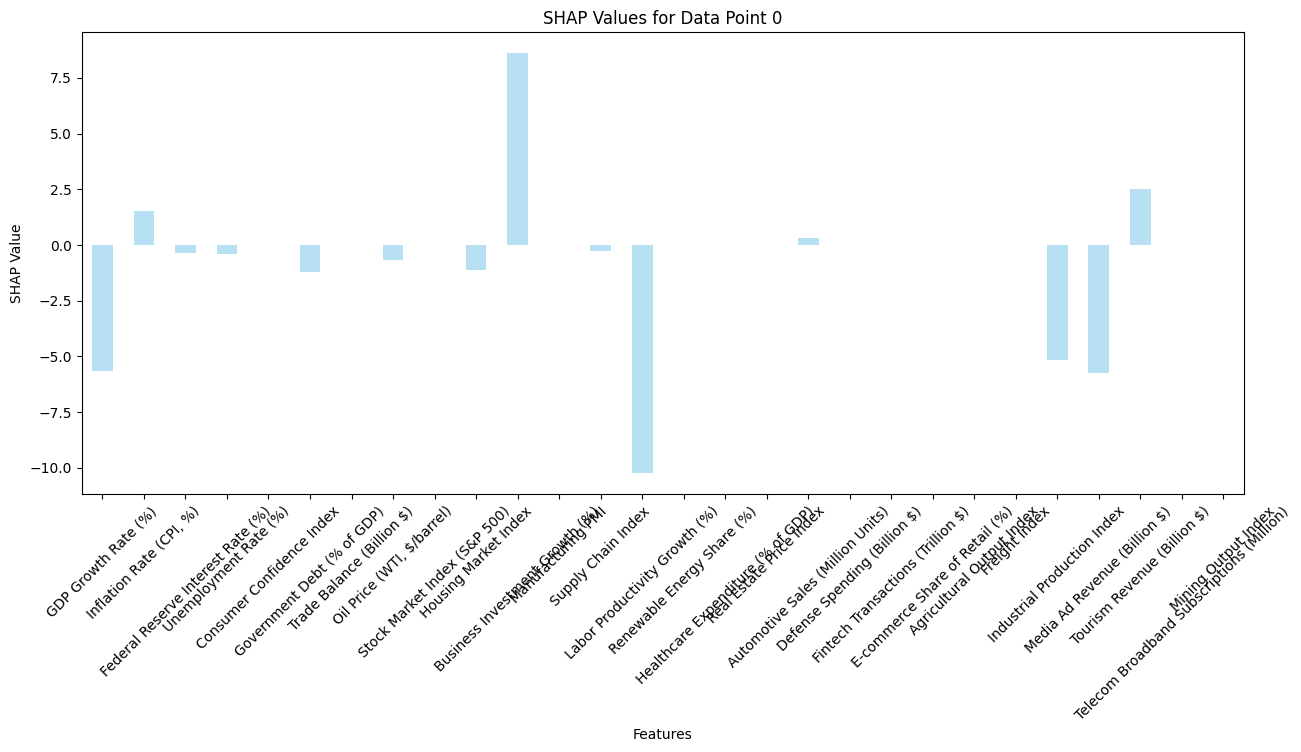

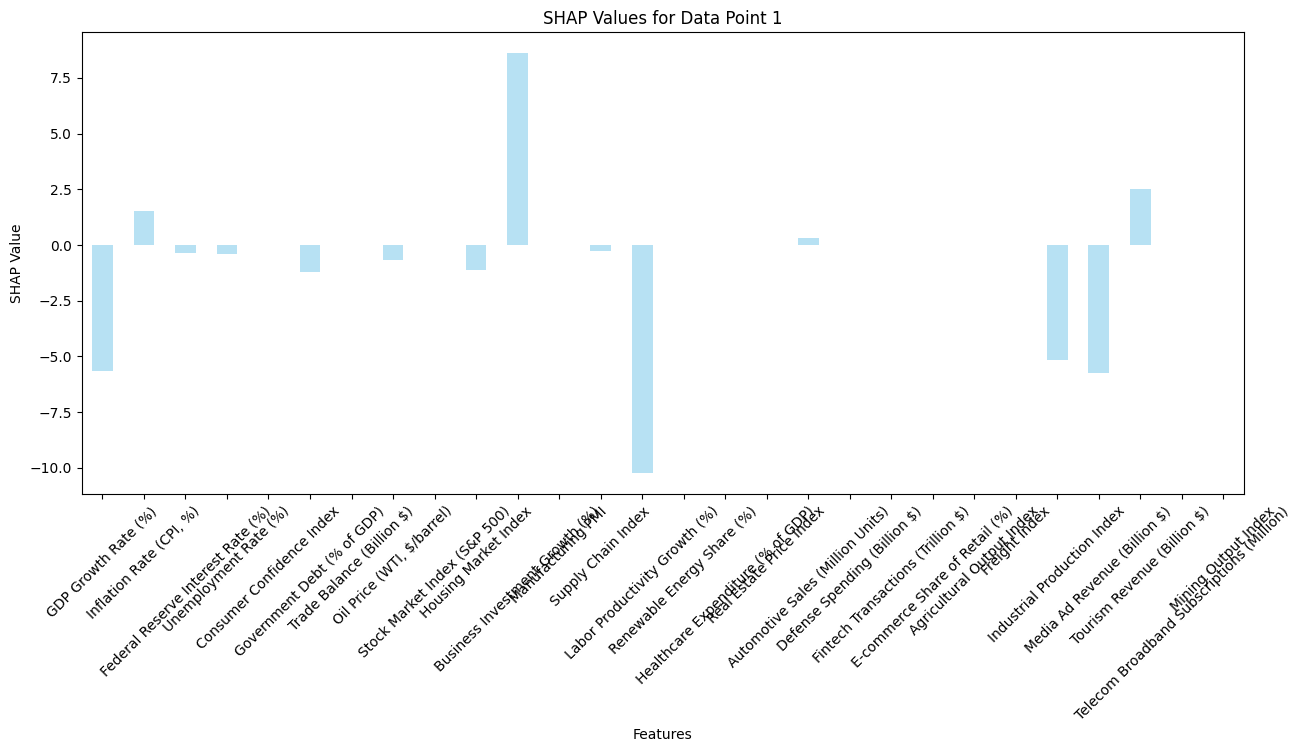

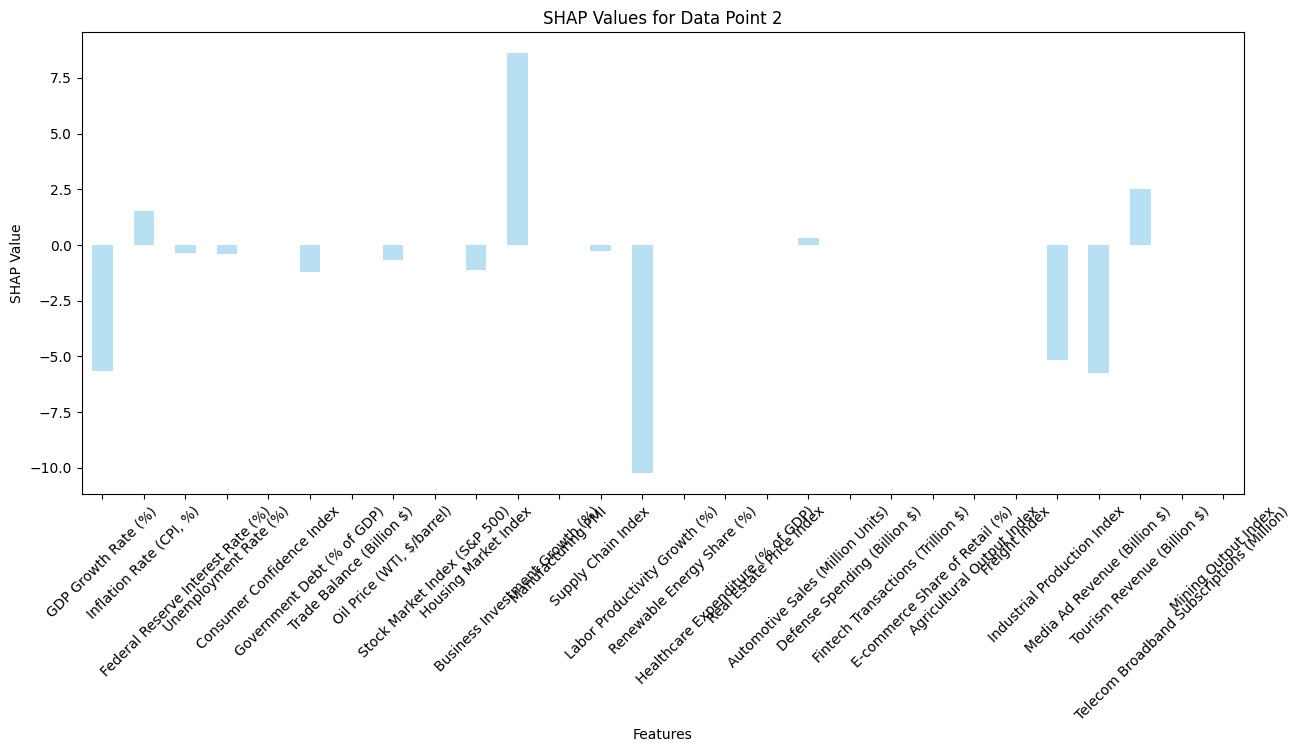

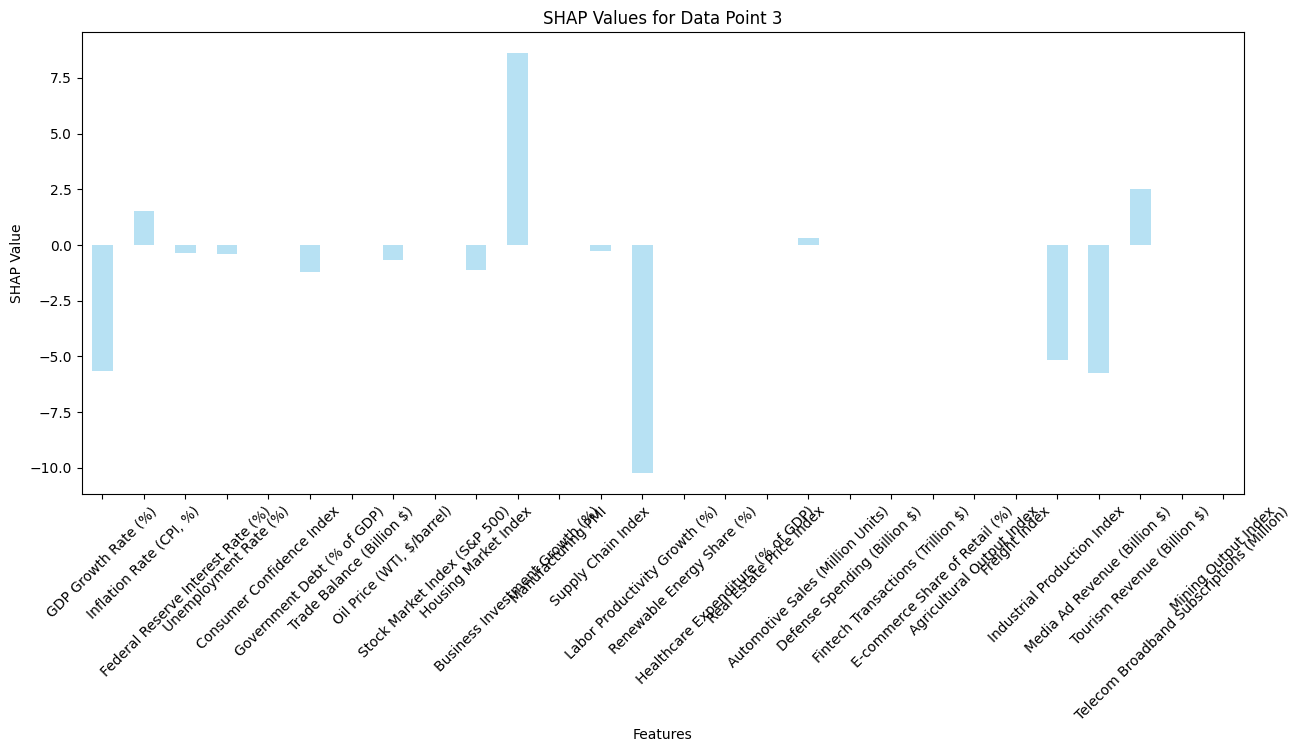

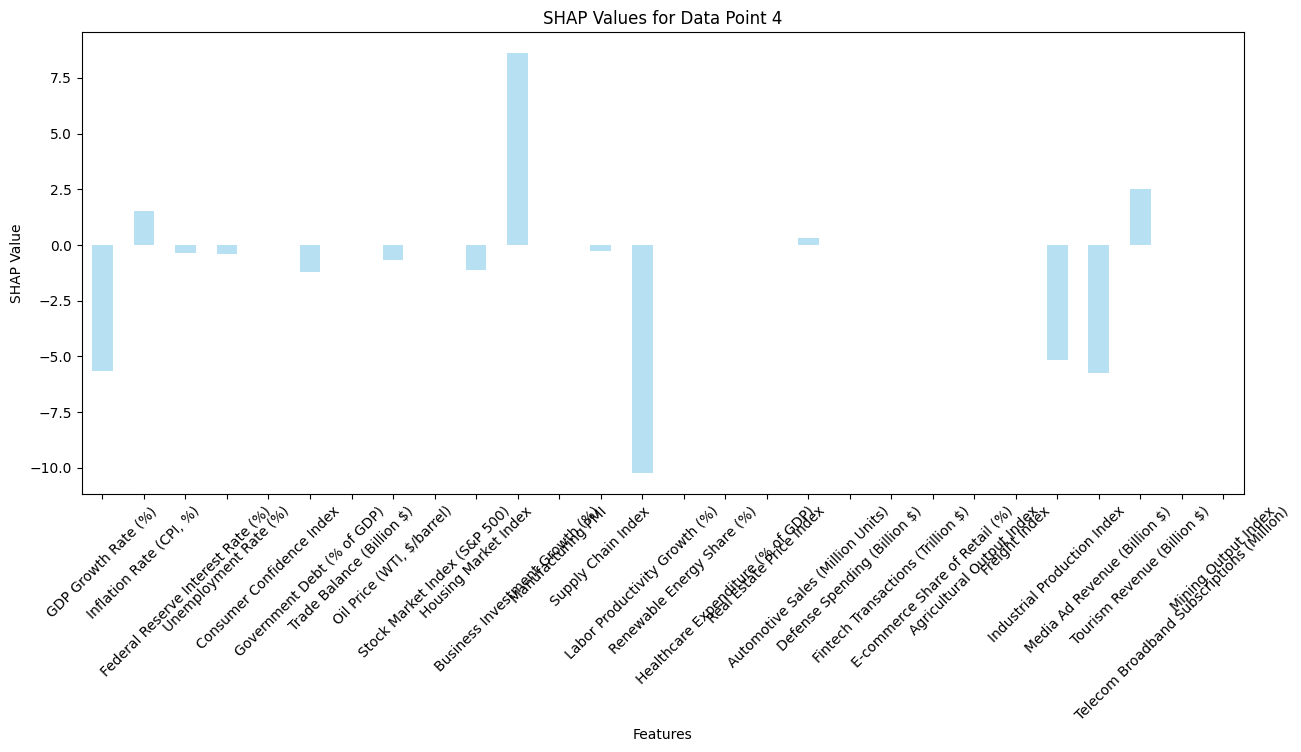

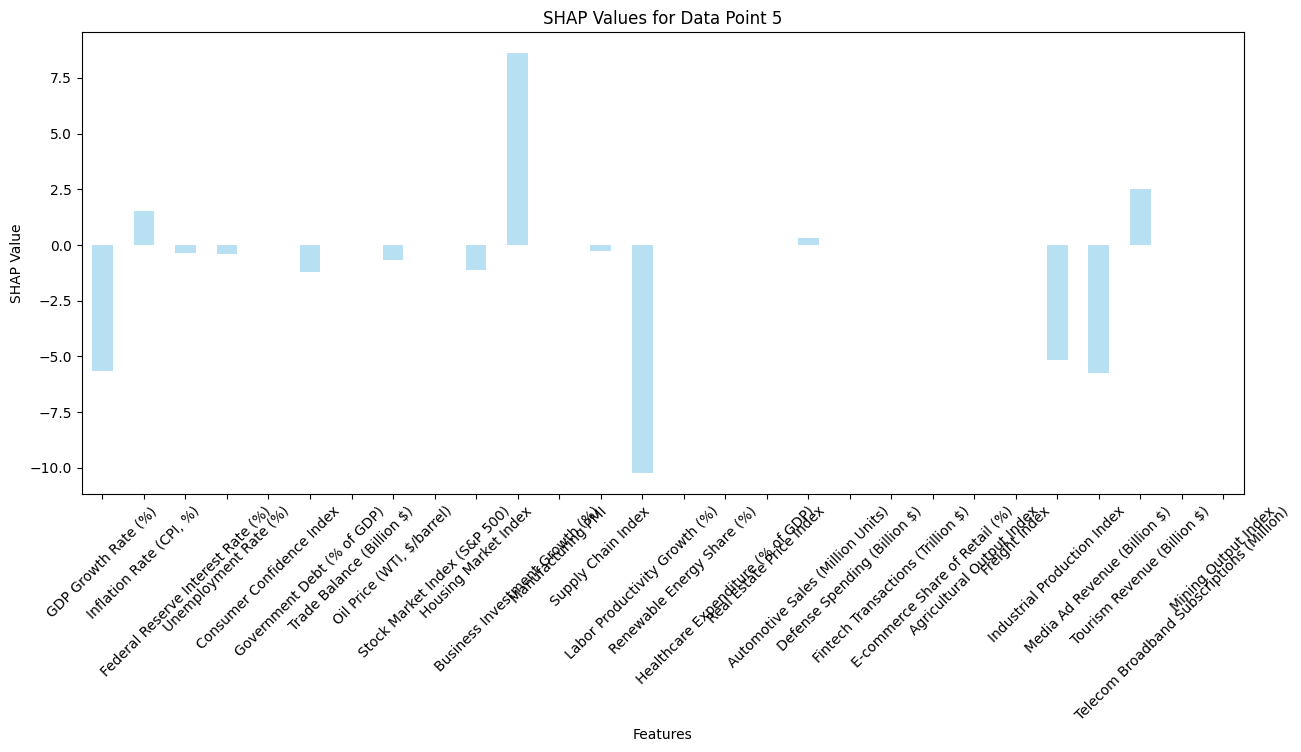

In [28]:
# --- 🔵 Import Necessary Library ---
import matplotlib.pyplot as plt  # For creating visualizations, especially bar plots

# --- 🔵 Plot SHAP Values for Each Data Point ---
# Assuming 'shap_df' is the DataFrame containing SHAP values for all features and data points
# This loop iterates over each data point (row) in 'shap_df' and creates a bar plot showing the SHAP values for each feature.

# Iterate over each row in the shap_df DataFrame (representing a single data point)
for idx, row in shap_df.iterrows():
    # Set up the figure size for each plot (ensures consistent size for all plots)
    plt.figure(figsize=(15, 6))
    
    # Plot the SHAP values for the current data point (row) as a bar chart
    # 'skyblue' for color, 'alpha=0.6' for transparency, 'legend=False' removes legend from the plot
    row.plot(kind='bar', color='skyblue', alpha=0.6, legend=False)
    
    # Set plot title, labels, and axis ticks
    plt.title(f'SHAP Values for Data Point {idx}')  # Title indicating the data point index
    plt.xlabel('Features')  # Label for the x-axis (features)
    plt.ylabel('SHAP Value')  # Label for the y-axis (SHAP value for each feature)
    
    # Rotate x-axis labels (features) by 45 degrees for better readability
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.show()  # Show the plot for the current data point (each plot is displayed separately)
